# Deep Network Training

This notebook trains several neural networks to predict seabirds' dives from GPS data.

Dataset: Peruvian Boobies trajectories sampled at 5, 15 and 30s

Network Architecture:

* FCNet : fully connected network (dense layer)
* CNNet : basic convolutional network
* UNet : U-Network with convolutional layers



## connect to drive

In [1]:
# mount google drive
from google.colab import drive
drive.mount("/content/drive/")

%cd drive/My\ Drive/THESIS/BirdDL

Mounted at /content/drive/
/content/drive/My Drive/THESIS/BirdDL


## data & libraries

In [ ]:
!pip install pytorch-lightning

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

In [4]:
from utils.dataloader import *
from utils.model import *

In [5]:
data_train = pd.read_csv('./data/SV_train.csv')
data_validation = pd.read_csv('./data/SV_validation.csv')
data_test = pd.read_csv('./data/SV_test.csv')

## Dataset 5s


In [6]:
resolution = 5

train = format_data(data_train, resolution)
val = format_data(data_validation, resolution)
test = format_data(data_test, resolution)

### FCNet

In [7]:
## Dataloader
window = 21
variable = ('step_speed', 'step_direction', 'gaps')
batch_size = 1024
W = 30

train_set = TrajDataSet(train, window, variable, transform=transforms.Compose([Center(), ToTensor()]))
train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True)

val_set = TrajDataSet(val, window, variable, transform=transforms.Compose([Center(), ToTensor()]))
val_loader = DataLoader(val_set, batch_size = batch_size, shuffle = False)

In [8]:
## Model Training
%%time

model = Lightning(FCNet(window, len(variable)), W)
earlystopping = EarlyStopping('val_loss')
modelcheckpoint = ModelCheckpoint(
    dirpath = './results',
    filename = 'SV_'+model.model.name+'_'+str(resolution)+'s--{epoch}-{val_loss:.2f}-{train_loss:.2f}',
    monitor = 'val_loss')

trainer = Trainer(max_epochs=20, progress_bar_refresh_rate=20, gpus = 0,
                  callbacks=[modelcheckpoint, earlystopping],
                  deterministic = True,
                  benchmark = True,
                  logger = False)


trainer.fit(model, train_loader, val_loader)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1304: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  "GPU available but not used. Set the gpus flag in your trainer"

  | Name  | Type  | Params
--------------------------------
0 | model | FCNet | 558 K 
--------------------------------
558 K     Trainable params
0         Non-trainable params
558 K     Total params
2.234     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

CPU times: user 7min 14s, sys: 2.36 s, total: 7min 16s
Wall time: 7min 14s


0.886521236920517


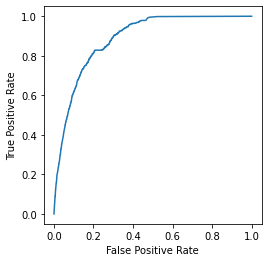

In [9]:
## Model testing

model = Lightning.load_from_checkpoint(modelcheckpoint.best_model_path, model=FCNet(window, len(variable)), weight = W)
model.eval()
test = model.predict(test, window, variable)
roc_x, roc_y = model.roc(test['FCNet'], test['dive'])

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.plot(roc_x, roc_y)
print(-np.trapz(roc_y, roc_x))

### CNNet

In [10]:
## Dataloader
window = 20
variable = ('step_speed', 'step_direction', 'gaps')
batch_size = 1024
W = 30

train_set = TrajDataSet(train, window, variable, transform=ToTensor())
train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True)

val_set = TrajDataSet(val, window, variable, transform=ToTensor())
val_loader = DataLoader(val_set, batch_size = batch_size, shuffle = False)

In [11]:
## Model training
%%time

model = Lightning(CNNet(len(variable)), W)
earlystopping = EarlyStopping('val_loss')
modelcheckpoint = ModelCheckpoint(
    dirpath = './results',
    filename = 'SV_'+model.model.name+'_'+str(resolution)+'s--{epoch}-{val_loss:.2f}-{train_loss:.2f}',
    monitor = 'val_loss')

trainer = Trainer(max_epochs=20, progress_bar_refresh_rate=20, gpus = 1,
                  callbacks=[modelcheckpoint, earlystopping],
                  deterministic = True,
                  benchmark = True,
                  logger = False)

trainer.fit(model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory ./results exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type  | Params
--------------------------------
0 | model | CNNet | 3.6 K 
--------------------------------
3.6 K     Trainable params
0         Non-trainable params
3.6 K     Total params
0.015     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

CPU times: user 15min 48s, sys: 6.06 s, total: 15min 54s
Wall time: 15min 55s


0.9426722760487242


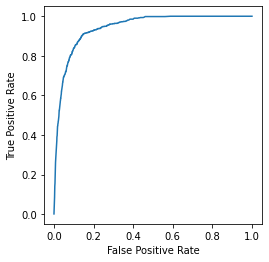

In [12]:
## Model testing

model = Lightning.load_from_checkpoint(modelcheckpoint.best_model_path, model=CNNet(len(variable)), weight = W)
model.eval()
test = model.predict(test, window, variable)
roc_x, roc_y = model.roc(test['CNNet'], test['dive'])

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.plot(roc_x, roc_y)
print(-np.trapz(roc_y, roc_x))

### UNet

In [13]:
## Model training
%%time

model = Lightning(UNet(len(variable)), W)
earlystopping = EarlyStopping('val_loss')
modelcheckpoint = ModelCheckpoint(
    dirpath = './results',
    filename = 'SV_'+model.model.name+'_'+str(resolution)+'s--{epoch}-{val_loss:.2f}-{train_loss:.2f}',
    monitor = 'val_loss')

trainer = Trainer(max_epochs=20, progress_bar_refresh_rate=20, gpus = 1,
                  callbacks=[modelcheckpoint, earlystopping],
                  deterministic = True,
                  benchmark = True,
                  logger = False)

trainer.fit(model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory ./results exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | UNet | 18.9 K
-------------------------------
18.9 K    Trainable params
0         Non-trainable params
18.9 K    Total params
0.076     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

CPU times: user 7min 56s, sys: 2.55 s, total: 7min 59s
Wall time: 7min 56s


0.9584499127885698


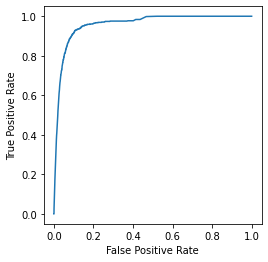

In [14]:
## Model testing

model = Lightning.load_from_checkpoint(modelcheckpoint.best_model_path, model=UNet(len(variable)), weight = W)
model.eval()
test = model.predict(test, window, variable)
roc_x, roc_y = model.roc(test['UNet'], test['dive'])

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.plot(roc_x, roc_y)
print(-np.trapz(roc_y, roc_x))

In [15]:
test.to_csv('./results/SV_'+str(resolution)+'s.csv', index = False)

## Dataset 15s


In [16]:
resolution = 15

train = format_data(data_train, resolution)
val = format_data(data_validation, resolution)
test = format_data(data_test, resolution)

### FCNet

In [17]:
## Dataloader
window = 21
variable = ('step_speed', 'step_direction', 'gaps')
batch_size = 1024
W = 30

train_set = TrajDataSet(train, window, variable, transform=transforms.Compose([Center(), ToTensor()]))
train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True)

val_set = TrajDataSet(val, window, variable, transform=transforms.Compose([Center(), ToTensor()]))
val_loader = DataLoader(val_set, batch_size = batch_size, shuffle = False)

In [18]:
## Model Training
%%time

model = Lightning(FCNet(window, len(variable)), W)
earlystopping = EarlyStopping('val_loss')
modelcheckpoint = ModelCheckpoint(
    dirpath = './results',
    filename = 'SV_'+model.model.name+'_'+str(resolution)+'s--{epoch}-{val_loss:.2f}-{train_loss:.2f}',
    monitor = 'val_loss')

trainer = Trainer(max_epochs=20, progress_bar_refresh_rate=20, gpus = 0,
                  callbacks=[modelcheckpoint, earlystopping],
                  deterministic = True,
                  benchmark = True,
                  logger = False)


trainer.fit(model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory ./results exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1304: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  "GPU available but not used. Set the gpus flag in your trainer"

  | Name  | Type  | Params
--------------------------------
0 | model | FCNet | 558 K 
--------------------------------
558 K     Trainable params
0         Non-trainable params
558 K     Total params
2.234     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

CPU times: user 2min 17s, sys: 874 ms, total: 2min 18s
Wall time: 2min 17s


0.818592509705977


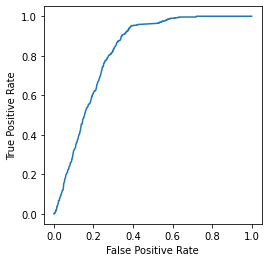

In [19]:
## Model testing

model = Lightning.load_from_checkpoint(modelcheckpoint.best_model_path, model=FCNet(window, len(variable)), weight = W)
model.eval()
test = model.predict(test, window, variable)
roc_x, roc_y = model.roc(test['FCNet'], test['dive'])

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.plot(roc_x, roc_y)
print(-np.trapz(roc_y, roc_x))

### CNNet

In [20]:
## Dataloader
window = 20
variable = ('step_speed', 'step_direction', 'gaps')
batch_size = 1024
W = 30

train_set = TrajDataSet(train, window, variable, transform=ToTensor())
train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True)

val_set = TrajDataSet(val, window, variable, transform=ToTensor())
val_loader = DataLoader(val_set, batch_size = batch_size, shuffle = False)

In [21]:
## Model training
%%time

model = Lightning(CNNet(len(variable)), W)
earlystopping = EarlyStopping('val_loss')
modelcheckpoint = ModelCheckpoint(
    dirpath = './results',
    filename = 'SV_'+model.model.name+'_'+str(resolution)+'s--{epoch}-{val_loss:.2f}-{train_loss:.2f}',
    monitor = 'val_loss')

trainer = Trainer(max_epochs=20, progress_bar_refresh_rate=20, gpus = 1,
                  callbacks=[modelcheckpoint, earlystopping],
                  deterministic = True,
                  benchmark = True,
                  logger = False)

trainer.fit(model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory ./results exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type  | Params
--------------------------------
0 | model | CNNet | 3.6 K 
--------------------------------
3.6 K     Trainable params
0         Non-trainable params
3.6 K     Total params
0.015     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

CPU times: user 6min 14s, sys: 2.14 s, total: 6min 16s
Wall time: 6min 15s


0.9122751070885917


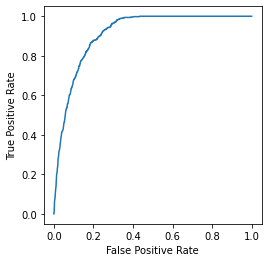

In [22]:
## Model testing

model = Lightning.load_from_checkpoint(modelcheckpoint.best_model_path, model=CNNet(len(variable)), weight = W)
model.eval()
test = model.predict(test, window, variable)
roc_x, roc_y = model.roc(test['CNNet'], test['dive'])

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.plot(roc_x, roc_y)
print(-np.trapz(roc_y, roc_x))

### UNet

In [23]:
## Model training
%%time

model = Lightning(UNet(len(variable)), W)
earlystopping = EarlyStopping('val_loss')
modelcheckpoint = ModelCheckpoint(
    dirpath = './results',
    filename = 'SV_'+model.model.name+'_'+str(resolution)+'s--{epoch}-{val_loss:.2f}-{train_loss:.2f}',
    monitor = 'val_loss')

trainer = Trainer(max_epochs=20, progress_bar_refresh_rate=20, gpus = 1,
                  callbacks=[modelcheckpoint, earlystopping],
                  deterministic = True,
                  benchmark = True,
                  logger = False)

trainer.fit(model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory ./results exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | UNet | 18.9 K
-------------------------------
18.9 K    Trainable params
0         Non-trainable params
18.9 K    Total params
0.076     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

CPU times: user 3min 9s, sys: 1.08 s, total: 3min 10s
Wall time: 3min 10s


0.9270294971026319


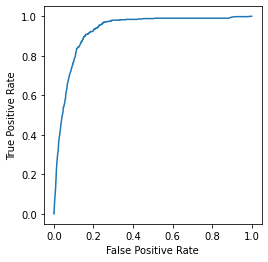

In [24]:
## Model testing

model = Lightning.load_from_checkpoint(modelcheckpoint.best_model_path, model=UNet(len(variable)), weight = W)
model.eval()
test = model.predict(test, window, variable)
roc_x, roc_y = model.roc(test['UNet'], test['dive'])

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.plot(roc_x, roc_y)
print(-np.trapz(roc_y, roc_x))

In [25]:
test.to_csv('./results/SV_'+str(resolution)+'s.csv', index = False)

## Dataset 30s


In [26]:
resolution = 30

train = format_data(data_train, resolution)
val = format_data(data_validation, resolution)
test = format_data(data_test, resolution)

### FCNet

In [27]:
## Dataloader
window = 21
variable = ('step_speed', 'step_direction', 'gaps')
batch_size = 1024
W = 30

train_set = TrajDataSet(train, window, variable, transform=transforms.Compose([Center(), ToTensor()]))
train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True)

val_set = TrajDataSet(val, window, variable, transform=transforms.Compose([Center(), ToTensor()]))
val_loader = DataLoader(val_set, batch_size = batch_size, shuffle = False)

In [28]:
## Model Training
%%time

model = Lightning(FCNet(window, len(variable)), W)
earlystopping = EarlyStopping('val_loss')
modelcheckpoint = ModelCheckpoint(
    dirpath = './results',
    filename = 'SV_'+model.model.name+'_'+str(resolution)+'s--{epoch}-{val_loss:.2f}-{train_loss:.2f}',
    monitor = 'val_loss')

trainer = Trainer(max_epochs=20, progress_bar_refresh_rate=20, gpus = 0,
                  callbacks=[modelcheckpoint, earlystopping],
                  deterministic = True,
                  benchmark = True,
                  logger = False)


trainer.fit(model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory ./results exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1304: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  "GPU available but not used. Set the gpus flag in your trainer"

  | Name  | Type  | Params
--------------------------------
0 | model | FCNet | 558 K 
--------------------------------
558 K     Trainable params
0         Non-trainable params
558 K     Total params
2.234     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

CPU times: user 1min 57s, sys: 884 ms, total: 1min 58s
Wall time: 1min 58s


0.8204462232484688


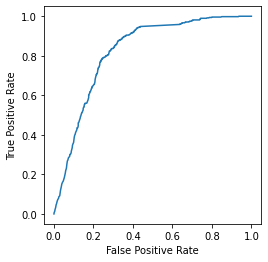

In [29]:
## Model testing

model = Lightning.load_from_checkpoint(modelcheckpoint.best_model_path, model=FCNet(window, len(variable)), weight = W)
model.eval()
test = model.predict(test, window, variable)
roc_x, roc_y = model.roc(test['FCNet'], test['dive'])

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.plot(roc_x, roc_y)
print(-np.trapz(roc_y, roc_x))

### CNNet

In [30]:
## Dataloader
window = 20
variable = ('step_speed', 'step_direction', 'gaps')
batch_size = 1024
W = 30

train_set = TrajDataSet(train, window, variable, transform=ToTensor())
train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True)

val_set = TrajDataSet(val, window, variable, transform=ToTensor())
val_loader = DataLoader(val_set, batch_size = batch_size, shuffle = False)

In [31]:
## Model training
%%time

model = Lightning(CNNet(len(variable)), W)
earlystopping = EarlyStopping('val_loss')
modelcheckpoint = ModelCheckpoint(
    dirpath = './results',
    filename = 'SV_'+model.model.name+'_'+str(resolution)+'s--{epoch}-{val_loss:.2f}-{train_loss:.2f}',
    monitor = 'val_loss')

trainer = Trainer(max_epochs=20, progress_bar_refresh_rate=20, gpus = 1,
                  callbacks=[modelcheckpoint, earlystopping],
                  deterministic = True,
                  benchmark = True,
                  logger = False)

trainer.fit(model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory ./results exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type  | Params
--------------------------------
0 | model | CNNet | 3.6 K 
--------------------------------
3.6 K     Trainable params
0         Non-trainable params
3.6 K     Total params
0.015     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

CPU times: user 2min 53s, sys: 1.08 s, total: 2min 54s
Wall time: 2min 54s


0.848309026390545


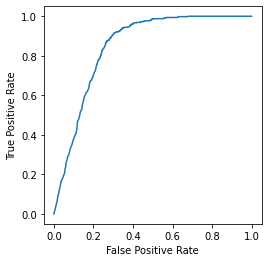

In [32]:
## Model testing

model = Lightning.load_from_checkpoint(modelcheckpoint.best_model_path, model=CNNet(len(variable)), weight = W)
model.eval()
test = model.predict(test, window, variable)
roc_x, roc_y = model.roc(test['CNNet'], test['dive'])

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.plot(roc_x, roc_y)
print(-np.trapz(roc_y, roc_x))

### UNet

In [33]:
## Model training
%%time

model = Lightning(UNet(len(variable)), W)
earlystopping = EarlyStopping('val_loss')
modelcheckpoint = ModelCheckpoint(
    dirpath = './results',
    filename = 'SV_'+model.model.name+'_'+str(resolution)+'s--{epoch}-{val_loss:.2f}-{train_loss:.2f}',
    monitor = 'val_loss')

trainer = Trainer(max_epochs=20, progress_bar_refresh_rate=20, gpus = 1,
                  callbacks=[modelcheckpoint, earlystopping],
                  deterministic = True,
                  benchmark = True,
                  logger = False)

trainer.fit(model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory ./results exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | UNet | 18.9 K
-------------------------------
18.9 K    Trainable params
0         Non-trainable params
18.9 K    Total params
0.076     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

CPU times: user 2min 54s, sys: 1.09 s, total: 2min 55s
Wall time: 2min 55s


0.9149503427404766


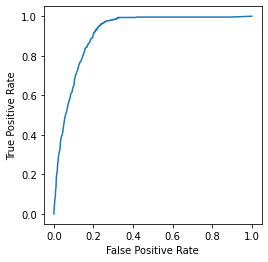

In [34]:
## Model testing

model = Lightning.load_from_checkpoint(modelcheckpoint.best_model_path, model=UNet(len(variable)), weight = W)
model.eval()
test = model.predict(test, window, variable)
roc_x, roc_y = model.roc(test['UNet'], test['dive'])

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.plot(roc_x, roc_y)
print(-np.trapz(roc_y, roc_x))

In [35]:
test.to_csv('./results/SV_'+str(resolution)+'s.csv', index = False)